In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import os, inspect, datetime, logging, numpy as np, pandas as pd, scipy as sp
from scipy.spatial.distance import pdist, cdist
import seaborn as sns, matplotlib.pyplot as plt


In [ ]:
#export
__file = inspect.getfile(lambda: None)

ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(__file), '.'))
LOG_FILE = os.path.join(ROOT_DIR, 'log.txt')

basename = os.path.basename(LOG_FILE)
logger = logging.getLogger(basename)

logging.basicConfig(
    filename=LOG_FILE, 
    level=logging.INFO#.DEBUG,
    format='%(asctime)s\t%(levelname)s:%(message)s',
    datefmt='%d/%m/%Y %I:%M:%S %p',
    filemode='w'
)

In [ ]:
VALID_SIGMAS = 'minmax median std knn'.split()
def validate_sigma(sigma, logger=None):
    is_known = sigma in VALID_SIGMAS or callable(sigma)
    message = (
        f'sigma ({sigma}) is {"" if is_known else "not "}known or callable.\n'
        f'known sigmas include {VALID_SIGMAS}'
    )
    if logger: logger.info(message)
    if not is_known:
        raise ValueError(message)

In [ ]:
#export 
def gauss_kernel(
    data1,
    data2,
    sigma='knn',
    k=5,
    a=2,
    fac=1,
    logger=None
):
    '''
https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/gauss_kernel.m
% DEGREES    compute degree and sparsity estimates of data   https://arxiv.org/abs/1802.04927
%   Authors: Ofir Lindenbaum, Jay S. Stanely III.
% 
% Usage:
%         K = degrees(data1, data2, varargin) Build a kernel over data1,
%         data2
%         [K,sigma] = degrees(data1, data2, varargin) Return kernel
%         bandwidth sigma
%
% Input: 
%       data1           
%               N x D Data matrix. N rows are measurements, D columns are features.
%                   Accepts: 
%                       numeric
%       data2       If data2 == data1, then a traditional kernel is built.        
%               N x D Data matrix. N rows are measurements, D columns are features.
%                   Accepts: 
%                       numeric
%   varargin: 
%       sigma      (default = 'knn')
%               Gaussian kernel bandwidth. 
%                   Accepts:    
%                        'std'- standard deviation of the distances
%                        'knn' - adaptive bandwidth,eg  kth neighbor distance
%                        'minmax'-  min-max on the distance matrix       
%                        'median'- the median of the distances      
%                         function handle - @(d) f(d) = scalar or N-length 
%                                   vector where d is an NxN distance matrix.    
%                         scalar - pre-computed bandwidth
%
%       k               (default = 5)
%               k-Nearest neighbor distance to use if sigma = 'knn'
%                   Accepts:
%                       positive scalars
%       a               (default = 2)
%               Alpha-kernel decay parameter. 2 is Gaussian kernel.
%                   Accepts:
%                       positive scalars
%       fac             (default = 1)
%               Rescale kernel bandwidth
%                   Accepts:
%                       positive scalars
% Output:
%       K
%               Kernel over data1, data2
%       sigma
%               N x 1 (adaptive) or scalar (constant) estimated kernel bandwidth
    '''
    validate_sigma(sigma, logger)
    
    D = cdist(data1, data2)
    N = D.shape[1]
    if sigma == 'minmax':
        min_dev = np.min(D + np.eye(D.shape[0]) * (10 ** 15))
        eps_val = np.max(min_dev)
        sigma = 2 * (eps_val ** 2)        

    elif sigma == 'median':
        sigma = np.median(np.median(D))

    elif sigma == 'std':
        # sigma = std(mean(D))
        sigma = np.std(np.mean(D, axis=0))

    elif sigma == 'knn':
        knn_dist = np.sort(D)
        # sigma = knn_dist(k+1,:);
        sigma = knn_dist[k-1, :]

    elif isinstance(sigma, (int, float)):
        sigma = sigma

    elif callable(sigma):
        sigma = sigma(D)

    else:
        pass
    sigma = sigma * fac

    # K = bsxfun(@rdivide, D, sigma);
    K = np.apply_along_axis(np.divide, 0, D, sigma)
    K = np.exp(-np.power(K, a))
    
    K[np.isnan(K)] = 0
    K[np.where(K < 1e-3)] = 0
    
    if K.shape[0] == K.shape[1]:
        K = (K + K.T) / 2
    
    return K, sigma

In [ ]:
data1 = np.arange(25).reshape(5, 5)
data2 = np.zeros((5, 5))
data2[0, 1] = 1
# data2=data1

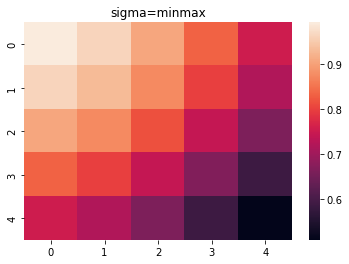

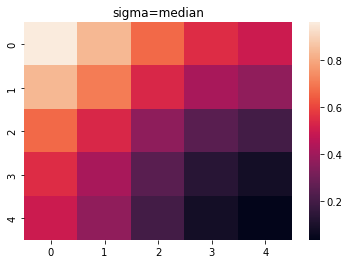

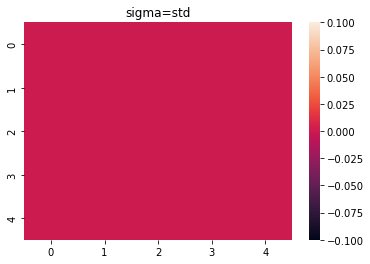

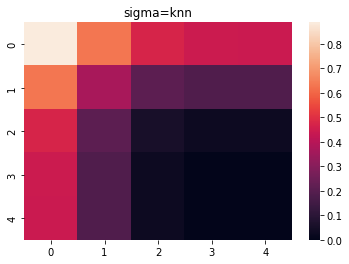

In [ ]:
for sigma in VALID_SIGMAS:
    K, sig = gauss_kernel(data1, data2, k=2, sigma=sigma)
    fig = plt.figure()
    ax = sns.heatmap(K)
    ax.set_title(f'sigma={sigma}')
    ax

In [ ]:
#export
def degrees(
    data,
    sigma='std',
    k=5,
    a=2,
    fac=1,
    logger=None
):
    '''
    https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/degrees.m

% DEGREES    compute degree and sparsity estimates of data   https://arxiv.org/abs/1802.04927
%   Authors: Ofir Lindenbaum, Jay S. Stanely III.
% 
% Usage:
%         d_hat = degrees(data, varargin) Estimate manifold degrees d_hat
%         [d_hat, s_hat] = degrees(data, varargin) Estimate sparsity s_hat = 1./d_hat 
%         [d_hat, s_hat, sigma] = degrees(data, varargin) Return estimated kernel bandwidth
%
% Input: 
%       data           
%               N x D Data matrix. N rows are measurements, D columns are features.
%                   Accepts: 
%                       numeric
%   varargin: 
%       sigma      (default = 'std')
%               Gaussian kernel bandwidth. 
%                   Accepts:    
%                        'std'- standard deviation of the distances
%                        'knn' - adaptive bandwidth,eg  kth neighbor distance
%                        'minmax'-  min-max on the distance matrix       
%                        'median'- the median of the distances      
%                         function handle - @(d) f(d) = scalar or N-length 
%                                   vector where d is an NxN distance matrix.    
%                         scalar - pre-computed bandwidth
%
%       k               (default = 5)
%               k-Nearest neighbor distance to use if sigma = 'knn'
%                   Accepts:
%                       positive scalars
%       a               (default = 2)
%               Alpha-kernel decay parameter. 2 is Gaussian kernel.
%                   Accepts:
%                       positive scalars
%       fac             (default = 1)
%               Rescale kernel bandwidth
%                   Accepts:
%                       positive scalars
% Output:
%       d_hat
%               N x 1 vector of the degree at each point in data of size N
%       s_hat
%               N x 1 vector of the sparsity at each point, s_hat=1./d_hat
%       sigma
%               N x 1 (adaptive) or scalar (constant) estimated kernel bandwidth
%  
    '''
    validate_sigma(sigma, logger)
    N = data.shape[1]
    K, sigma = gauss_kernel(
        data, data, sigma=sigma, k=k, a=a, fac=fac, logger=logger
    )
    p = np.sum(K, axis=0)
    d_hat = (p * (N)) / np.sum(p)
    s_hat = np.divide(1, d_hat)
    return d_hat, s_hat, sigma

In [ ]:
degrees(data1, sigma='std')

(array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.]), 3.7416573867739413)

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

def local_covariance(
    data,
    k=5
):
    local_cov = []
    for row in data:
        neigh = NearestNeighbors(n_neighbors=k)
        neigh.fit(row.reshape(-1, 1))
        points = neigh.kneighbors(row.reshape(-1, 1), return_distance=False)
        local_cov.append(np.cov(points))
    return np.array(local_cov)

In [ ]:
data1, local_covariance(data1)

(array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]]),
 array([[[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-

In [ ]:
data2, local_covariance(data2)

(array([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[[ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ],
         [-0.75,  2.5 , -0.75, -0.75, -0.75],
         [ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ]],
 
        [[ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ]],
 
        [[ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ]],
 
        [[ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 

In [ ]:
def feature_scale(x):
    fp = np.divide((x - np.min(x)), np.max(x) - np.min(x))
    return fp

In [ ]:
def numpts(
    degree,
    noise_cov=1,
    kernel_sigma=1,
    dim=None,
    M=0,
    equalize=False,
    suppress=False,
    logger=None
):
    '''
    https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/numpts.m
    %NUMPTS Compute the number of new points to generate around each point in a
    %       dataset     https://arxiv.org/abs/1802.04927
    % Authors: Ofir Lindenbaum, Jay S. Stanley III.
    %
    % Usage:
    %         npts = numpts(degree, varargin) Generate npts, the estimate of
    %         the number of points generate according to degree.
    %
    % Input: 
    %       degree
    %               Degree estimate of the N x D data
    %                   Accepts:
    %                       N x 1 numeric
    %   varargin:
    %       noise_cov       (default = 1)
    %               Noise bandwidth used for downstream data generation
    %                   Accepts:
    %                       Scalar - uniform Gaussian noise variance
    %                       N x 1 cell - contains D x D local covariance
    %                       matrices for Gaussian generated noise
    %
    %       kernel_sigma        (default = 1)
    %               Degree estimate bandwidth
    %                   Accepts:
    %                       N x 1 numeric - adaptive bandwidth 
    %                       Scalar - uniform bandwidth
    %
    %                  
    %       dim             (default = D if available from noise_cov, else required)       
    %               Generated noise dimension
    %                   Accepts:
    %                       Scalar
    %
    %       M               (default = 0)
    %               Number of points to generate.  Can affect strength of density
    %               equalization.
    %                   Accepts: 
    %                        positive scalars 
    %                        If (M && equalize) then density equalization will be
    %                        scaled by M.  M < N will negatively impact density
    %                        equalization, M << N is not recommended and M <<< N may fail.
    %                        If (~M && equalize) then density equalization will not be
    %                        scaled
    %                        If (M && ~equalize) then approximately M points will be
    %                        generated according to a constant difference of the
    %                        max density
    %                        If (~M && ~equalize) then M = approx. N points will be
    %                        generated.
    %
    %       equalize        (default = false)
    %               Density equalization.  Can be affected by M.
    %                   Accepts: 
    %                       logical / scalar
    %
    %       suppress (default = false)
    %               Enable/disable point generation errors
    %
    % Output
    %       npts the number of points to generate at each point
    %     
    '''
    N = len(degree)
    const = np.max(degree)
    number_estimate = np.zeros((N, 1))
    if equalize:
        if isinstance(noise_cov, (int, float)):
            if logger: logger.info('Density equalizaton according to scalar noise covariance...')
            number_estimate = (const - degree) * \
                ( (kernel_sigma**2 + noise_cov**2) / ((2) * noise_cov**2) ) ** (dim/2)
        
        else:
            if logger: logger.info('Density equalizaton according to local noise covariance...')
            for i in range(N):
                if not isinstance(noise_cov, (int, float)):
                    sig = kernel_sigma[i]
                else:
                    sig = kernel_sigma
                number_estimate[i] = (const - degree[i]) * np.apply_along_axis(
                    np.power, 0,
                    np.linalg.det(
                        np.eye(noise_cov[i].shape) + \
                            np.apply_over_axes(np.divide, 0, noise_cov[i], (2 * np.power(sig, 2))) 
                    ),
                    0.5
                )
        if bool(M):
            if logger: logger.info('Applying total generation constraint M.')
            number_save = number_estimate
            number_sum = np.sum(number_estimate)
            if M / number_sum < 1e-1:
                message = (
                    f'{M / number_sum * 100}% of equalized total. '
                    'Output will reflecct equalization. Increased M suggested.'
                )
                if logger: logger.warning(message)
            number_estimate = (number_estimate * M) / (np.sum(number_estimate) + 1e-17)
            npts = np.floor(number_estimate)
        else:
            npts = np.floor(number_estimate)
    else:
        if logger: logger.info('Generating without density equalization')
        if not bool(M):
            if logger: logger.info('No M supplied, M = N')
            M = N
        number_estimate = (const - degree)
        number_estimate = (number_estimate * M) / (np.sum(number_estimate) + 1e17)

        npts = np.floor(number_estimate)
    
    if np.sum(npts, axis=0) == 0:
        if logger: logger.warning('Point generation estimate < 0, either provide/increase M or decrease noise_cov.')
        npts = np.ones((N, 1))
        npts = np.ones((N, ))
    elif np.sum(npts) > 10**4:
        if logger: logger.warning('Point generation estimate > 1e4, either provide/decrease M or increase noise_cov.')

    return npts

In [ ]:
def generate(data, npts, noise_cov, labels):
    '''
    https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/generate.m
%GENERATE Generate randomly sampled Gaussian points around each point in a dataset    https://arxiv.org/abs/1802.04927
% Authors: Ofir Lindenbaum, Jay S. Stanley III.
%
% Usage:
%         random_points = generate(data, npts, noise_cov) Generate npts(i)
%         points centered at data(i,:) according to noise_cov(i)
% 
% Input: 
%       data           
%               N x D Data matrix. N rows are measurements, D columns are features.
%                   Accepts: 
%                       numeric
%       npts
%               number of points to generate around each point in data
%                   Accepts:
%                       N x 1 vector (will round to integer)
%
%       noise_cov
%               Covariance to use for point-generating Gaussians
%                   Accepts:
%                       N x 1 cell of D x D covariance matrices
%                       Scalar
%       labels
%               Labels to add to new points
% Output:
%       random_points
%               sum(npts) x D Noisy generated points
%     
    '''    
    rep_centers = []
    rep_cov = []
    j = 0
    labels_out = []
    if isinstance(noise_cov, (float, int)): # constant cov, no need to replicate cov.
        for i, row in enumerate(data):
            # replicate data[i] to make npts[i] centers for mvnrnd
            new_center = np.tile(row.T, (1, npts[i]))
            rep_centers.append(new_center)# = [rep_centers, new_center]
            if labels:
                new_labels = np.tile(labels[i], (1, npts[i]))
                labels_out = [labels_out, new_labels]
        # generate
        random_points = np.random.Generator.multivariate_normal(
            rep_centers.T, noise_cov * np.ones(1, data.shape[1])
        )
    else:
        for i, row in enumerate(data):
            # replicate centers npts[i] times
            new_center = np.tile(row.T, (1, npts[i]))
            
            
            if labels:
                new_labels = np.tile(labels[i], (1, npts[i]))
                labels_out = [labels_out, new_labels]
            j = j + npts[i]
            
            # rep_centers = [rep_centers, new_center]
            rep_centers.append(new_center)
            if npts[i] != 0:
                # replicate the covariance matrix                       
                if i == 0:
                    rep_cov = np.tile(noise_cov[i], (1, 1, npts[i]))                      
                else:
                    rep_cov = np.concatenate(
                        (
                            rep_cov,
                            np.tile(noise_cov[i], (1, 1, npts[i]))
                        ),
                        axis=2                    
                    )        
        
        print(np.array(rep_centers, dtype=object).T.shape, rep_cov.shape)
        random_points = np.apply_over_axes(
            np.random.multivariate_normal, 0, 
            np.array(rep_centers, dtype=object).T, rep_cov
        ) 
        # random_points = np.random.multivariate_normal(
        #     np.array(rep_centers, dtype=object).T, rep_cov
        # )
        # random_points = np.random.Generator.multivariate_normal(
        #     np.array(rep_centers, dtype=object).T, rep_cov
        # )
    return random_points, labels_out


In [ ]:
# numpts(
#     degree,
#     noise_cov=1,
#     kernel_sigma=1,
#     dim=None,
#     M=0,
#     equalize=False,
#     suppress=False,
#     logger=None
# )
# generate(data, npts, noise_cov, labels)
# magic(
#     data, kernel, t=1, rescale=True,
#     logger=None
# )
# mgc_magic(
#     X, 
#     Y, 
#     s_hat, 
#     sigma = 'knn',
#     k = 5,
#     a = 2,
#     fac = 1,
#     t = 1,
#     magic_rescale = 1,
#     logger = None
# )

In [ ]:
def magic(
    data, kernel, t=1, rescale=True,
    logger=None
):
    '''
    https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/magic.m
% MAGIC   Markov Affinity based Gaussian Imputation of Cells 
%   See
%       https://www.biorxiv.org/content/early/2017/02/25/111591
%       https://arxiv.org/abs/1802.04927
%   Implementation Authors: Ofir Lindenbaum, Jay S. Stanley III.
%   Publication Authors: David van Dijk et al. 
% Usage:
%         data_imputed = magic(data, kernel, t, rescale) Impute data using kernel for t time steps with rescaling
%         [~, diffusion_operator] = magic(data, kernel, t, rescale) Diffusion operator used for data_imputed
% Input: 
%       data           
%               N x D Data matrix. N rows are measurements, D columns are features.
%                   Accepts: 
%                       numeric
%       kernel      
%               N x N Kernel or affinity matrix. 
%                   Accepts:
%                       numeric
%       t       (default = 1)
%               Scalar. Time steps to apply MAGIC for.  Controls low pass filter cutoff.
%       rescale (default = true)
%               Rescale 95th percentile of imputed data to match original data.
% Output:
%      data_imputed 
%               M x D Data points imputed via MAGIC using kernel.
%      diffusion_operator
%               M x M Markov matrix built from kernel.
%
    '''
    if (
        data.shape[0] != kernel.shape[0] and
        data.shape[1] != kernel.shape[0]
    ):
        if logger: logger.warning('Data does not match kernel size')
    else:
        data = data.T
    
    # build diffusion operator
    diffusion_degree = np.diag(
        np.sum(kernel, axis=1) ** -1
    ) 
    diffusion_degree[np.isinf(diffusion_degree)] = 0
    diffusion_operator = diffusion_degree * kernel

    data_imputed = data

    for i in range(t):
        data_imputed = diffusion_operator * data_imputed
    
    if rescale:
        data_imputed = np.multiply(
            data_imputed, 
            np.divide(
                np.percentile(data, 95), 
                np.percentile(data_imputed, 95)
            )
        )
    return data_imputed, diffusion_operator

In [ ]:
def mgc_magic(
    X, 
    Y, 
    s_hat, 
    sigma = 'knn',
    k = 5,
    a = 2,
    fac = 1,
    t = 1,
    magic_rescale = 1,
    logger = None
):
    '''
    https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/mgc_magic.m
    % MGC_MAGIC   Measure-based Gaussian Correlation Kernel w/ MAGIC  https://arxiv.org/abs/1802.04927
    %   Authors: Ofir Lindenbaum, Jay S. Stanley III.
    %
    % Usage:
    %         new_data = mgc_magic(X,Y, s_hat, varargin) Impute Y using an MGC kernel between X via the measure S_hat
    % Input: 
    %       X           
    %               N x D Data matrix. N rows are measurements, D columns are features.
    %                   Accepts: 
    %                       numeric
    %       Y       M x D Data matrix.  M rows are measurements, D columns are features.
    %                   Accepts:
    %                       numeric
    %       s_hat   M x 1 measure vector. M entries correspond to measures on the rows of Y.
    %                   Accepts:
    %                       M x 1 numeric
    %
    %   varargin:
    %       sigma    (default = 'knn')
    %               MGC kernel bandwidth. 
    %                   Accepts:    
    %                        'std'- standard deviation of the distances
    %                        'knn' - adaptive bandwidth,eg  kth neighbor distance
    %                        'minmax'-  min-max on the distance matrix       
    %                        'median'- the median of the distances      
    %                         function handle - @(d) f(d) = scalar or N-length 
    %                                   vector where d is an NxN distance matrix.    
    %                         scalar - pre-computed bandwidth
    %
    %       k         (default = 5)
    %               k-Nearest neighbor distance to use if sigma = 'knn'
    %               Accepts:
    %                       positive scalars
    %       a         (default = 2)
    %               Alpha-kernel decay parameter for kernel. 2 is Gaussian kernel.
    %               Accepts:
    %                       positive scalars
    %       fac         (default = 1)
    %               Rescale mgc kernel bandwidth
    %                   Accepts:
    %                       positive scalars
    %       t       (default = 1)
    %               Apply MGC MAGIC to diffuse new points.
    %               mgc_magic = 0 disables this function.
    %               mgc_magic > 0 applies mgc_magic steps of diffusion. 
    %                   Accepts:
    %                       Scalar
    %       magic_rescale   (default = 1)
    %               Rescale new points after magic.
    %                   Accepts:
    %                       positive scalars
    % Output:
    %      new_data 
    %               M x D New points corrected using MGC MAGIC through X.
    %      mgc_kernel
    %               M x M MGC kernel built over Y through X via s_hat
    %      mgc_diffusion_operator
    %               M x M row stochastic MGC markov matrix / diffusion operator
    '''
    if t == 0:
        new_data = Y
        if logger: logger.warning('mgc_magic was passed t=0, no mgc_magic was performed')
    new_to_old = gauss_kernel(X, Y, sigma, a, k, fac)
    old_to_new = gauss_kernel(X, Y, sigma, a, k, fac)

    new_to_old_sparsity = np.apply_along_axis(
        np.multiply, 0,
        new_to_old, s_hat
    )
    mgc_kernel = new_to_old_sparsity * old_to_new
    mgc_kernel = np.divide( (mgc_kernel + magic_rescale.T) , 2)
    new_data, mgc_diffusion_operator = magic(Y, mgc_kernel, t, magic_rescale)
    return new_data, mgc_kernel, mgc_diffusion_operator

In [ ]:
#export
def sugar(
    data, 
    labels=[],
    noise_cov='knn',
    noise_k=5,
    sparsity_idx=[],
    degree_sigma='std',
    degree_k=5,
    degree_a=2,
    degree_fac=1,
    M=0,
    equalize=False,
    mgc_magic=1,
    mgc_sigma='knn',
    mgc_k=5,
    mgc_a=2,
    mgc_fac=1,
    magic_rescale=1,
    suppress=False,
    logger=None
):
    '''
    % SUGAR   Geometry-based Data Generation    https://arxiv.org/abs/1802.04927
    %   Authors: Ofir Lindenbaum, Jay S. Stanley III.
    %
    % Usage:
    %         Y = sugar(data, varargin) Generate Y using estimated manifold geometry over data
    %         [~, out_labels] = sugar(data, varargin) Generated labels
    %         [~, ~, d_hat] = sugar(data, varargin) Degree estimate of data
    %         [~, ~, ~, s_hat] = sugar(data, varargin) Sparsity estimate of data
    %         [~, ~, ~, ~, sigma] = sugar(data, varargin) Bandwidth used for degree computation
    %         [~, ~, ~, ~, ~, noise] = sugar(data, varargin) Covariance estimate around each x_i in X.
    %         [~, ~, ~, ~, ~, ~, npts] = sugar(data, varargin) Number of points estimate 
    %         [~, ~, ~, ~, ~, ~, ~, random_points] = sugar(data, varargin) Random points before MGC correction
    %         [~, ~, ~, ~, ~, ~, ~, ~, mgc_kernel] = sugar(data, varargin) MGC kernel over the new points through the data via s_hat
    %         [~, ~, ~, ~, ~, ~, ~, ~, ~, mgc_diffusion_operator] = sugar(data, varargin) MGC diffusion operator used for MAGIC
    % Input: 
    %       data           
    %               N x D Data matrix. N rows are measurements, D columns are features.
    %                   Accepts: 
    %                       numeric
    %
    %   varargin:
    %       labels           (default = [])
    %               N x 1 vector of classifier labels.
    %                   Accepts numeric
    %       noise_cov        (default = 'knn')
    %               Bandwidth of Gaussian noise.
    %                   Accepts:
    %                       'knn' - (local covariance estimation for tuning noise)
    %                       scalar - constant noise bandwidth
    %`      noise_k      (default = 5)
    %               Neighborhood size for covariance estimation
    %                   Accepts:
    %                       positive scalars
    %       sparsity_idx (default = [])
    %               Column indexes for sparsity estimation dimensions.
    %                   [] : Estimate sparsity in all dimensions.
    %       degree_sigma    (default = 'std')
    %               Diffusion kernel bandwidth. 
    %                   Accepts:    
    %                        'std'- standard deviation of the distances
    %                        'knn' - adaptive bandwidth,eg  kth neighbor distance
    %                        'minmax'-  min-max on the distance matrix       
    %                        'median'- the median of the distances      
    %                         function handle - @(d) f(d) = scalar or N-length 
    %                                   vector where d is an NxN distance matrix.    
    %                         scalar - pre-computed bandwidth
    %
    %       degree_k         (default = 5)
    %               k-Nearest neighbor distance to use if degree_sigma = 'knn'
    %               Accepts:
    %                       positive scalars
    %       degree_a         (default = 2)
    %               Alpha-kernel decay parameter for degree computation. 2 is Gaussian kernel.
    %               Accepts:
    %                       positive scalars
    %       degree_fac         (default = 1)
    %               Rescale mgc kernel bandwidth
    %                   Accepts:
    %                       positive scalars
    %       M               (default = 0)
    %               Number of points to generate.  Can affect strength of density
    %               equalization.
    %                   Accepts: 
    %                        positive scalars 
    %                        If (M && equalize) then density equalization will be
    %                        scaled by M.  M < N will negatively impact density
    %                        equalization, M << N is not recommended and M <<< N may fail.
    %                        If (~M && equalize) then density equalization will not be
    %                        scaled
    %                        If (M && ~equalize) then approximately M points will be
    %                        generated according to a constant difference of the
    %                        max density
    %                        If (~M && ~equalize) then M = approx. N points will be
    %                        generated.
    %
    %       equalize        (default = false)
    %               Density equalization.  Can be affected by M.
    %                   Accepts: 
    %                       logical / scalar
    %
    %       mgc_magic       (default = 1)
    %               Apply MGC MAGIC to diffuse new points.
    %               mgc_magic = 0 disables this function.
    %               mgc_magic > 0 applies mgc_magic steps of diffusion. 
    %                   Accepts:
    %                       Scalar
    %       mgc_sigma    (default = 'knn')
    %               Diffusion kernel bandwidth. 
    %                   Accepts:    
    %                        'std'- standard deviation of the distances
    %                        'knn' - adaptive bandwidth,eg  kth neighbor distance
    %                        'minmax'-  min-max on the distance matrix       
    %                        'median'- the median of the distances      
    %                         function handle - @(d) f(d) = scalar or N-length 
    %                                   vector where d is an NxN distance matrix.    
    %                         scalar - pre-computed bandwidth
    %       mgc_a               (default = 2)
    %               Alpha-kernel decay parameter for MGC. 2 is Gaussian kernel.
    %                   Accepts:
    %                        positive scalars
    %       mgc_k         (default = 5)
    %               k-Nearest neighbor distance to use if mgc_sigma = 'knn'
    %                   Accepts:
    %                       positive scalars
    %       mgc_fac         (default = 1)
    %               Rescale mgc kernel bandwidth
    %                   Accepts:
    %                       positive scalars
    %       magic_rescale   (default = 1)
    %               Rescale new points after magic.
    %                   Accepts:
    %                       positive scalars
    %       suppress (default = false)
    %               Enable/disable point generation errors
    %                   Accepts: 
    %                       logical / scalar
    % Output:
    %      Y 
    %               M x D New points generated by SUGAR
    %      out_labels
    %               M x 1 New labels corresponding to Y.
    %      d_hat
    %               N x 1 Degree estimate of data
    %      s_hat
    %               N x 1 Sparsity estimate of data
    %      sigma
    %               N x 1 or Scalar sigma used for d_hat computation
    %      noise
    %               Scalar - Constant noise bandwidth
    %               N x D x D cell of local covariance matrices on X
    %      npts
    %               N x 1 Number of points generated for each point in X
    %      random_points
    %               M x D Random points generated around X
    %      mgc_kernel
    %               M x M kernel matrix of Y through data over s_hat
    %      mgc_diffusion_operator
    %               M x M Makov matrix of mgc_kernel
    %
    '''
    if logger: logger.info('Initializing SUGAR')
    # [data, params] = init(data, varagin{:})

    dim = data.shape[1]

    if logger: logger.info('Obtaining Degree Estimate')
    if len(sparsity_idx) == 0:
        sparsity_idx = np.zeros((data.shape[1]))

    d_hat, s_hat, degree_sigma = degrees(
        data, sigma=degree_sigma,
        k=degree_k, a=degree_a, fac=degree_fac,
        logger=logger
    )
    if logger: logger.info(f'd_hat: {d_hat}')
    if logger: logger.info(f's_hat: {s_hat}')
    if logger: logger.info(f'degree_sigma: {degree_sigma}')

    if noise_cov == 'knn':
        if logger: logger.info('Local Covariance estimation')
        noise = local_covariance(data, noise_k)
        noise_cov = noise
    
    if logger: logger.info('Estimating number of points to generate')
    npts = numpts(
        d_hat, noise_cov=noise_cov, kernel_sigma=degree_sigma, dim=dim, M=M,
        equalize=equalize, suppress=suppress, logger=logger
    )

    if logger: logger.info('Generating points')
    random_points, out_labels = generate(data, npts, noise_cov, labels)

    if mgc_magic > 0:
        if logger: logger.info('Diffusing points via MGC Magic')
        Y, mgc_kernel, mgc_diffusion_operator = mgc_magic(
            X=data, Y=random_points, 
            s_hat=s_hat,  sigma=mgc_sigma, 
            a=mgc_a, k=mgc_k, t=mgc_magic,
            fac=mgc_fac, magic_rescale=magic_rescale,
            logger=logger
        )
        pass
    else:
        Y = random_points
        mgc_kernel = []
        mgc_diffusion_operator = []

    return Y, out_labels, d_hat, s_hat, sigma, noise, npts, random_points, mgc_kernel, mgc_diffusion_operator

In [ ]:
sugar(
    data1, 
    labels=[],
    noise_cov='knn',
    noise_k=5,
    sparsity_idx=[],
    degree_sigma='std',
    degree_k=5,
    degree_a=2,
    degree_fac=1,
    M=0,
    equalize=False,
    mgc_magic=1,
    mgc_sigma='knn',
    mgc_k=5,
    mgc_a=2,
    mgc_fac=1,
    magic_rescale=1,
    suppress=False,
    logger=logger
)

(5, 1, 5) (1, 5, 25)


TypeError: _apply_over_axes_dispatcher() takes 3 positional arguments but 4 were given